In [1]:
from __future__ import division
%matplotlib inline
import matplotlib.pyplot as plt
from postBornCrossSpectra import PostBorn_Bispec
import numpy as np
import Cosmology as C
import pickle
from scipy.integrate import simps
from scipy.interpolate import RectBivariateSpline
from classy import Class

import copy
import kernels
plt.style.use(['seaborn-colorblind','paper'])
plt.style.use('classic')

In [2]:
plotpath = './CrossPostBorn/results/plots/vanessa/'

In [3]:
zmin = 1e-5
zmax = 1090.

kmin = 1e-4
kmax = 50

cosmo = C.Planck2015

a     = np.linspace(1./(1.+zmin),1./(1.+zmax),500)  
z     = 1./a-1.

data  = C.CosmoData(cosmo[1],z)

LSST_bin  = 'all'

L     = np.logspace(1,4,100)


computing distances, derived parameters...
{'Neff': 3.046}
{'h': 0.68}
{'m_ncdm_tot': 0.0}
{'omega_m': 0.6608555034063286}


In [4]:
#compute 31 term seperately
def get_31_term(L,L1,M):
    res=[]
    for L_ in L:
        res+=[simps(M(L_,L1,grid=False)/L1,L1)]

    res= np.asarray(res)
    res*=-1/(2*np.pi)*L**2
    return res

In [5]:
# #compute correction following Krause&Hirata
def get_regularized_sum_of_terms_old(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2-2.*LL1/LL*nu)
            integrand =LL**2*LL1**3*(-LL1*nu+LL)**2*(-LL1+LL*nu)**2*(M(L_,LL1,grid=False)/L_**4/LL1**4-M(LL,LL1,grid=False)/LL**4/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

In [6]:
#compute correction following Krause&Hirata
def get_regularized_sum_of_terms(L,L1,phi,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            L_= LL*np.sqrt(1.+(LL1/LL)**2+2.*LL1/LL*nu)
            integrand =LL**2*LL1**3*(LL1*nu+LL)**2*(LL1+LL*nu)**2*(M(L_,LL1,grid=False)/L_**4/LL1**4-M(LL,LL1,grid=False)/LL**4/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

def get_second_sum_of_terms(L,L1,M,method='trapz'):
    nu = np.cos(phi)
    res=[]
    for LL in L:
        resL1=[]
        for LL1 in L1:
            integrand = LL1*(LL**2*LL1**2*(LL1*nu+LL)**2*(LL1+LL*nu)**2-LL**4*(LL*LL1*nu)**2)*(M(LL,LL1,grid=False)/LL**4/LL1**4)
            if method =='simps':
                resL1+=[simps(integrand,phi)]
            elif method =='trapz':
                resL1+=[np.trapz(integrand,phi)]
            elif method =='sum':
                resL1+=[np.sum(integrand*np.diff(phi)[0])]
        res+=[simps(resL1,L1)]
    res=4.*np.asarray(res)/(2*np.pi)**2
    return res

#angular integration by hand
def get_second_sum_of_terms_exact(L,L1,M):
    res=[]
    for LL in L:
        integrand = L1*(27./4.*LL**4*L1**4+LL**2*L1**6)*(M(LL,L1,grid=False)/LL**4/L1**4)
        res+=[simps(integrand,L1)]   
    return 4.*np.asarray(res)/4./np.pi

In [7]:
# first test for CMB lensing auto spectrum, change second kernel to initialize for cross
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.CMB_lens(data.chi_cmb,data)#kernels.gal_clus(kernels.dNdz_LSST,kernels.simple_bias,data,LSST_bin)

PB1 = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=100, lmax=30000, acc=2)

Initializing CLASS with halofit...
{'k_step_super': 0.0001, 'tol_perturb_integration': 1e-06, 'perturb_sampling_stepsize': 0.01, 'k_step_super_reduction': 0.1, 'k_max_tau0_over_l_max': 5.0, 'ln10^{10}A_s': 3.062, 'h': 0.68, 'z_max_pk': 1088.8072653000208, 'non linear': 'halofit', 'omega_cdm': 0.119, 'Omega_k': 0.0, 'k_pivot': 0.05, 'k_per_decade_for_pk': 20, 'P_k_max_1/Mpc': 101, 'k_min_tau0': 0.002, 'output': 'mPk', 'omega_b': 0.0223, 'n_s': 0.97, 'k_step_sub': 0.015, 'halofit_k_per_decade': 3000.0}
sigma8  0.829731969326
('zmax', 1088.8072653000208)


In [8]:
phi=np.linspace(0.,2.*np.pi,1000,endpoint=True)
L1=np.logspace(-1,5,400)
reskk1 = get_regularized_sum_of_terms(L,L1,phi,PB1.Mstarsp,method='trapz')
reskk1b= get_regularized_sum_of_terms_old(L,L1,phi,PB1.Mstarsp,method='trapz')
reskk2 = get_second_sum_of_terms(L,L1,PB1.Mstarsp,method='trapz')
reskk2b= get_second_sum_of_terms_exact(L,L1,PB1.Mstarsp)


/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in true_divide
  if __name__ == '__main__':
/home/nessa/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in multiply
  if __name__ == '__main__':


No handlers could be found for logger "matplotlib.legend"
/home/nessa/miniconda2/lib/python2.7/site-packages/matplotlib/scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


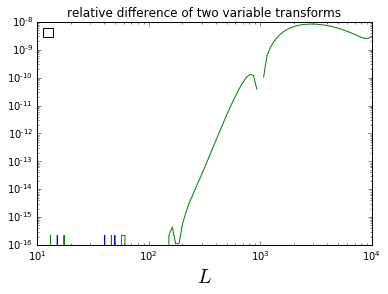

In [10]:
plt.figure()
plt.title('relative difference of two variable transforms')
plt.loglog(L, reskk1b/reskk1-1)
plt.loglog(L, -reskk1b/reskk1+1)
plt.xlabel('$L$',fontsize=20)
plt.legend(loc='best')
plt.show()
plt.savefig(plotpath+'firstIntegral_tests.pdf', bbox_inches='tight')

/home/nessa/miniconda2/lib/python2.7/site-packages/matplotlib/ticker.py:2206: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  "Data has no positive values, and therefore cannot be "


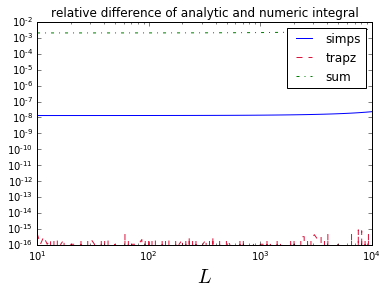

In [11]:
lstyles=['-','--','-.']
colors=['blue', 'crimson','green']
i=0
plt.figure()
plt.title('relative difference of analytic and numeric integral')
for method in ['simps','trapz','sum']:
    reskk_ = get_second_sum_of_terms(L,L1,PB1.Mstarsp,method=method)
    plt.loglog(L, reskk_/reskk2b-1,label=method,ls=lstyles[i],c=colors[i])
    plt.loglog(L, -reskk_/reskk2b+1,label=method,ls=lstyles[i],c=colors[i])
    i+=1
plt.xlabel('$L$',fontsize=20)
plt.legend()
plt.show()
plt.savefig(plotpath+'integral_tests.pdf', bbox_inches='tight')

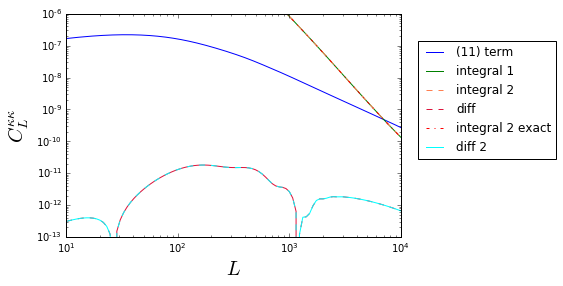

In [12]:
plt.figure()
plt.loglog(PB1.ls,PB1.CL_born,label='(11) term')
plt.loglog(L, -reskk1,label='integral 1')
plt.loglog(L, reskk2,ls='--',label='integral 2',color='coral')
plt.loglog(L, reskk1+reskk2,ls='--',label='diff',color='crimson')
plt.loglog(L, -(reskk1+reskk2),ls='-',color='crimson')
plt.loglog(L, reskk2b,ls='-.',label='integral 2 exact')
plt.loglog(L, reskk1+reskk2b,ls='-',label='diff 2 ',color='cyan')
plt.loglog(L, -(reskk1+reskk2b),ls='--',color='cyan')
plt.xlim(10,10000)
plt.ylim(1e-13,1e-6)
plt.legend(loc=(1.05,0.35))
plt.ylabel('$C_L^{\kappa\kappa}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_kk_pB_tests.pdf', bbox_inches='tight')
plt.show()

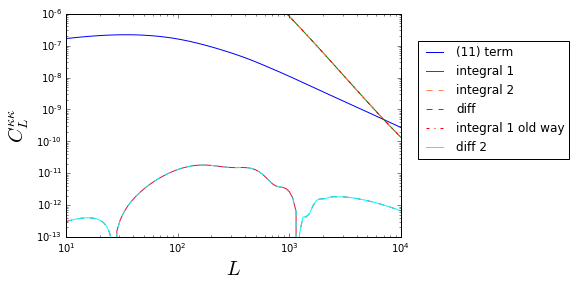

In [13]:
plt.figure()
plt.loglog(PB1.ls,PB1.CL_born,label='(11) term')
plt.loglog(L, -reskk1,label='integral 1')
plt.loglog(L, reskk2,ls='--',label='integral 2',color='coral')
plt.loglog(L, reskk1+reskk2,ls='--',label='diff',color='crimson')
plt.loglog(L, -(reskk1+reskk2),ls='-',color='crimson')
plt.loglog(L, reskk2b,ls='-.',label='integral 1 old way')
plt.loglog(L, reskk1b+reskk2b,ls='-',label='diff 2 ',color='cyan')
plt.loglog(L, -(reskk1b+reskk2b),ls='--',color='cyan')
plt.xlim(10,10000)
plt.ylim(1e-13,1e-6)
plt.legend(loc=(1.05,0.35))
plt.ylabel('$C_L^{\kappa\kappa}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.savefig(plotpath+'cl_kk_pB_tests_2.pdf', bbox_inches='tight')
plt.show()

In [ ]:
# first test for CMB lensing auto spectrum, change second kernel to initialize for cross
first_kernel  = kernels.CMB_lens(data.chi_cmb,data)
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.gal_clus(kernels.dNdz_LSST,kernels.simple_bias,data,LSST_bin)

PB2 = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=1e-4,k_max=200, lmax=60000, acc=1)

#(31)-term, multiply by two to get (31)+(13)


In [ ]:
plt.figure()
for L_ in [100,1000,10000]:
    dlnMdlnL1=L1*PB2.Mstarsp(L_,L1,dx=0,dy=1)/PB2.Mstarsp(L_,L1,dx=0,dy=0)
    plt.semilogx(L1,dlnMdlnL1[0],label='L=%d'%L_)
    
plt.legend()
plt.show()


In [ ]:
plt.figure()
for cc in [data.chi_cmb/10.,data.chi_cmb]:
    dlnM1dlnL1=L1*PB2.inner_int(cc,L1,dx=0,dy=1)/PB2.inner_int(cc,L1,dx=0,dy=0)
    plt.semilogx(L1,dlnM1dlnL1[0],label='chi=%d'%cc)
    
plt.legend(loc='best')
plt.show()

plt.figure()
for cc in [data.chi_cmb/10.,data.chi_cmb]:
    dlnM1dlnL1=PB2.inner_int(cc,L1,dx=0,dy=0)
    plt.semilogx(L1,dlnM1dlnL1[0],label='chi=%d'%cc)
    
plt.legend(loc='best')
plt.show()

In [ ]:

plt.figure()
plt.loglog(PB2.ls,PB2.CL_born,label='(11) term')
L1=np.logspace(-5,np.log10(60000),1000)
reskg = get_31_term(L,L1,PB2.Mstarsp)
plt.loglog(L,-reskg,label='(31) term')
L1=np.logspace(-1,np.log10(60000),1000)
reskg = get_31_term(L,L1,PB2.Mstarsp)
plt.loglog(L,-reskg,label='(31) term 2',ls='--')
plt.xlim(10,50000)
plt.legend()
plt.ylabel('$C_L^{\kappa g}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.ylim(1e-12,1e-6)
plt.savefig(plotpath+'cl_kg_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')

plt.show()

In [ ]:
PB2.Mstarsp(L,L1)

In [ ]:
# first test for CMB lensing auto spectrum, change second kernel to initialize for cross
first_kernel  = kernels.gal_lens((0,1),data, p_chi=kernels.p_delta(data,1.))
simple_kernel = kernels.CMB_lens(None,data)
second_kernel = kernels.gal_lens((0,1),data, p_chi=kernels.p_delta(data,1.))

PB3 = PostBorn_Bispec(data, zmin, data.z_cmb, first_kernel, second_kernel, simple_kernel, k_min=kmin,k_max=kmax, lmax=None, acc=1)

#(31)-term, multiply by two to get (31)+(13)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)

In [ ]:

plt.figure()
plt.loglog(PB3.ls,PB3.ls**2*PB3.CL_born/(2*np.pi),label='(11) term')
L1=np.logspace(-5,4)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)
plt.loglog(L,-L**2*resgamgam/(2*np.pi),label='(31) term')
L1=np.logspace(-1,4)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)
plt.loglog(L,-L**2*resgamgam/(2*np.pi),label='(31) term 2', ls='--')
plt.xlim(10,10000)
plt.legend(loc='upper left')
plt.ylabel('$C_L^{\gamma \gamma}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.grid()
plt.ylim(1e-10,1e-2)
plt.savefig(plotpath+'cl_gamgam_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')
plt.show()

In [ ]:
L1 = np.logspace(-3,np.log10(20000),400)
phi = np.linspace(0,2.*np.pi,400)
L = L1
term2 = get_22_term(L,L1,phi,PB2.Mstarsp)
resgamgam = get_31_term(L,L1,PB3.Mstarsp)
plt.figure()
plt.loglog(PB3.ls,PB3.ls**2*PB3.CL_born/(2*np.pi),label='(11) term')
plt.loglog(L,-L**2*resgamgam/(2*np.pi),label='(31) term')
plt.loglog(L,L**2*term2/(2*np.pi),label='(22) term')
plt.xlim(10,10000)
plt.legend(loc='upper left')
plt.ylabel('$C_L^{\gamma \gamma}$',fontsize=20)
plt.xlabel('$L$',fontsize=20)
plt.grid()
plt.ylim(1e-10,1e-2)
plt.savefig(plotpath+'cl_gamgam_pB_L1min%d.pdf'%(min(L1)), bbox_inches='tight')
plt.show()